# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 69.66%.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

Note: MSR Initialization was added because the training would not work without it.

In [25]:
import math
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # # MSR initialization
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x):
        # x = self.upsample(x)
        x = self.quant(x)
        x = self.maxpool1(self.conv1(x))

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dequant(x)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [4]:
def load_dataset(path='./data', batch_size=64):
  print("Loading the CIFAR10 dataset")

  transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), # scale RGB 0-255 to 0-1
    # normalize with known mean and std deviation of the CIFAR10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
  ])

  # train_transform = transforms.Compose([
  #   transforms.RandomCrop(32, padding=4),
  #   transforms.RandomHorizontalFlip(),
  #   transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
  #   transforms.ToTensor(),
  #   transforms.Normalize((0.4914, 0.4822, 0.4465),
  #                   (0.2023, 0.1994, 0.2010)),
  # ])
  train_transform = transforms.Compose([
    transforms.Resize(224),  # Resize before any augmentation
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
  ])

  # get training data
  train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transform)
  # get test data
  test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
  # load the training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8,pin_memory=True)
  # load the test data
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=8,pin_memory=True)

  print(f"Loaded train data: {len(train_loader.dataset)} total samples, {len(train_loader)} batches\n"
      f"Loaded test data: {len(test_loader.dataset)} total samples, {len(test_loader)} batches")

  return train_loader, test_loader

In [5]:
train_loader, test_loader = load_dataset()

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


## Train the model

In the cells below we define a function to visualize our training and train our model

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [7]:
def train_model(model,train_loader,test_loader,train=True,test=True,device='cpu',epochs=10,lr=1e-3):
  model.to(device)
  metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # TRAINING LOOP
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  criterion_test = nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


  for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}] ",end='')
    if train:
      model.train()
      train_loss, total_examples, correct = 0.0, 0, 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True) # zero gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs,labels) # get loss from cost function
        loss.backward() # backward propagation
        optimizer.step() # update gradients

        # train_loss += loss.item() # track total loss up to this point
        train_loss += loss.item() * labels.size(0)
        _, pred_ind = outputs.max(1) # get index of prediction (highest value)
        total_examples += labels.size(0) # update count for this epoch with batch size
        correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      # scheduler.step() 
    #   train_loss /= len(train_loader) # get average per batch
      train_loss /= total_examples # get average per example
      train_acc = 100.0 * correct / total_examples

      metrics["train_loss"].append(train_loss)
      metrics["train_acc"].append(train_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% ",end='')

      # VALIDATION/TEST
    if test:
      model.eval()
      test_loss, total_examples, correct = 0.0, 0, 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward pass
          loss = criterion_test(outputs,labels) # get loss from cost function
          test_loss += loss.item() * labels.size(0) # update loss
          _, pred_ind = outputs.max(1) # get index of prediction (highest value)
          total_examples += labels.size(0) # update count for this epoch with batch size
          correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      test_loss /= total_examples
      test_acc = 100.0 * correct / total_examples

      metrics["test_loss"].append(test_loss)
      metrics["test_acc"].append(test_acc)

      print(f"Test/Val Loss: {test_loss:.4f}, Test/Val Acc: {test_acc:.2f}%")

  return metrics

In [ ]:
# def init_weights_he(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

#     elif isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         nn.init.zeros_(m.bias)
        
# model_fp32 = SqueezeNetCIFAR10()
# model_fp32.apply(init_weights_he)
# # model_fp32.load_model('squeezenet_fp32.pth')

In [ ]:
# train, test = True, True
# epochs = 100
# fp32_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/100] 

/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 2.4593, Train Acc: 20.90% 

Test/Val Loss: 1.8687, Test/Val Acc: 29.72%
Epoch [2/100] 

Train Loss: 1.9504, Train Acc: 31.60% 

Test/Val Loss: 1.5776, Test/Val Acc: 41.95%
Epoch [3/100] 

Train Loss: 1.8491, Train Acc: 37.12% 

Test/Val Loss: 1.6379, Test/Val Acc: 40.72%
Epoch [4/100] 

Train Loss: 1.7566, Train Acc: 42.08% 

Test/Val Loss: 1.4224, Test/Val Acc: 50.36%
Epoch [5/100] 

Train Loss: 1.6859, Train Acc: 46.16% 

Test/Val Loss: 1.2764, Test/Val Acc: 54.62%
Epoch [6/100] 

Train Loss: 1.6332, Train Acc: 48.94% 

Test/Val Loss: 1.3072, Test/Val Acc: 55.00%
Epoch [7/100] 

Train Loss: 1.5829, Train Acc: 51.64% 

Test/Val Loss: 1.1739, Test/Val Acc: 60.58%
Epoch [8/100] 

Train Loss: 1.5425, Train Acc: 53.77% 

Test/Val Loss: 1.0982, Test/Val Acc: 62.65%
Epoch [9/100] 

Train Loss: 1.5171, Train Acc: 55.11% 

Test/Val Loss: 1.2493, Test/Val Acc: 56.12%
Epoch [10/100] 

Train Loss: 1.4806, Train Acc: 56.97% 

Test/Val Loss: 1.1036, Test/Val Acc: 61.29%
Epoch [11/100] 

Train Loss: 1.4571, Train Acc: 58.15% 

Test/Val Loss: 1.0515, Test/Val Acc: 64.03%
Epoch [12/100] 

Train Loss: 1.4392, Train Acc: 59.42% 

Test/Val Loss: 0.9820, Test/Val Acc: 66.36%
Epoch [13/100] 

Train Loss: 1.4119, Train Acc: 60.60% 

Test/Val Loss: 1.0043, Test/Val Acc: 67.48%
Epoch [14/100] 

Train Loss: 1.3846, Train Acc: 62.05% 

Test/Val Loss: 0.9500, Test/Val Acc: 68.72%
Epoch [15/100] 

Train Loss: 1.3713, Train Acc: 62.91% 

Test/Val Loss: 0.9326, Test/Val Acc: 68.90%
Epoch [16/100] 

Train Loss: 1.3499, Train Acc: 64.02% 

Test/Val Loss: 0.8995, Test/Val Acc: 71.66%
Epoch [17/100] 

Train Loss: 1.3389, Train Acc: 64.28% 

Test/Val Loss: 0.9345, Test/Val Acc: 70.88%
Epoch [18/100] 

Train Loss: 1.3160, Train Acc: 65.61% 

Test/Val Loss: 0.9166, Test/Val Acc: 69.93%
Epoch [19/100] 

Train Loss: 1.3114, Train Acc: 65.57% 

Test/Val Loss: 0.8757, Test/Val Acc: 72.80%
Epoch [20/100] 

Train Loss: 1.2957, Train Acc: 66.60% 

Test/Val Loss: 0.8792, Test/Val Acc: 71.45%
Epoch [21/100] 

Train Loss: 1.2828, Train Acc: 67.01% 

Test/Val Loss: 0.8264, Test/Val Acc: 72.09%
Epoch [22/100] 

Train Loss: 1.2826, Train Acc: 67.10% 

Test/Val Loss: 0.8364, Test/Val Acc: 72.72%
Epoch [23/100] 

Train Loss: 1.2647, Train Acc: 68.34% 

Test/Val Loss: 0.7798, Test/Val Acc: 74.12%
Epoch [24/100] 

Train Loss: 1.2643, Train Acc: 68.20% 

Test/Val Loss: 0.9179, Test/Val Acc: 71.97%
Epoch [25/100] 

Train Loss: 1.2519, Train Acc: 68.91% 

Test/Val Loss: 0.8095, Test/Val Acc: 73.41%
Epoch [26/100] 

Train Loss: 1.2535, Train Acc: 68.67% 

Test/Val Loss: 0.9586, Test/Val Acc: 72.98%
Epoch [27/100] 

Train Loss: 1.2380, Train Acc: 69.70% 

Test/Val Loss: 0.8309, Test/Val Acc: 75.43%
Epoch [28/100] 

Train Loss: 1.2342, Train Acc: 69.78% 

Test/Val Loss: 0.8886, Test/Val Acc: 73.18%
Epoch [29/100] 

Train Loss: 1.2217, Train Acc: 70.17% 

Test/Val Loss: 0.7451, Test/Val Acc: 76.57%
Epoch [30/100] 

Train Loss: 1.2186, Train Acc: 70.35% 

Test/Val Loss: 0.7963, Test/Val Acc: 75.63%
Epoch [31/100] 

Train Loss: 1.2148, Train Acc: 70.84% 

Test/Val Loss: 0.8164, Test/Val Acc: 74.69%
Epoch [32/100] 

Train Loss: 1.2124, Train Acc: 70.67% 

Test/Val Loss: 0.8297, Test/Val Acc: 75.54%
Epoch [33/100] 

Train Loss: 1.1998, Train Acc: 71.48% 

Test/Val Loss: 0.7132, Test/Val Acc: 77.98%
Epoch [34/100] 

Train Loss: 1.1938, Train Acc: 71.57% 

Test/Val Loss: 0.7044, Test/Val Acc: 77.41%
Epoch [35/100] 

Train Loss: 1.1875, Train Acc: 71.79% 

Test/Val Loss: 0.8004, Test/Val Acc: 76.03%
Epoch [36/100] 

Train Loss: 1.1806, Train Acc: 72.40% 

Test/Val Loss: 0.6552, Test/Val Acc: 78.58%
Epoch [37/100] 

Train Loss: 1.1870, Train Acc: 72.07% 

Test/Val Loss: 0.7475, Test/Val Acc: 77.12%
Epoch [38/100] 

Train Loss: 1.1762, Train Acc: 72.63% 

Test/Val Loss: 0.7261, Test/Val Acc: 77.92%
Epoch [39/100] 

Train Loss: 1.1781, Train Acc: 72.39% 

Test/Val Loss: 0.7355, Test/Val Acc: 78.00%
Epoch [40/100] 

Train Loss: 1.1749, Train Acc: 72.65% 

Test/Val Loss: 0.7279, Test/Val Acc: 77.75%
Epoch [41/100] 

Train Loss: 1.1688, Train Acc: 72.80% 

Test/Val Loss: 0.7603, Test/Val Acc: 75.80%
Epoch [42/100] 

Train Loss: 1.1646, Train Acc: 73.13% 

Test/Val Loss: 0.6781, Test/Val Acc: 79.16%
Epoch [43/100] 

Train Loss: 1.1606, Train Acc: 73.25% 

Test/Val Loss: 0.7423, Test/Val Acc: 75.78%
Epoch [44/100] 

Train Loss: 1.1555, Train Acc: 73.69% 

Test/Val Loss: 0.7284, Test/Val Acc: 79.70%
Epoch [45/100] 

Train Loss: 1.1495, Train Acc: 73.95% 

Test/Val Loss: 0.6852, Test/Val Acc: 78.03%
Epoch [46/100] 

Train Loss: 1.1504, Train Acc: 73.85% 

Test/Val Loss: 0.6617, Test/Val Acc: 78.59%
Epoch [47/100] 

Train Loss: 1.1451, Train Acc: 73.97% 

Test/Val Loss: 0.6831, Test/Val Acc: 77.57%
Epoch [48/100] 

Train Loss: 1.1509, Train Acc: 73.74% 

Test/Val Loss: 0.7263, Test/Val Acc: 79.35%
Epoch [49/100] 

Train Loss: 1.1379, Train Acc: 74.35% 

Test/Val Loss: 0.7420, Test/Val Acc: 76.34%
Epoch [50/100] 

Train Loss: 1.1334, Train Acc: 74.58% 

Test/Val Loss: 0.7102, Test/Val Acc: 78.96%
Epoch [51/100] 

Train Loss: 1.1312, Train Acc: 74.76% 

Test/Val Loss: 0.6640, Test/Val Acc: 79.55%
Epoch [52/100] 

Train Loss: 1.1336, Train Acc: 74.69% 

Test/Val Loss: 0.6686, Test/Val Acc: 80.23%
Epoch [53/100] 

Train Loss: 1.1202, Train Acc: 75.24% 

Test/Val Loss: 0.6606, Test/Val Acc: 80.17%
Epoch [54/100] 

Train Loss: 1.1258, Train Acc: 74.98% 

Test/Val Loss: 0.6960, Test/Val Acc: 78.66%
Epoch [55/100] 

Train Loss: 1.1184, Train Acc: 75.29% 

Test/Val Loss: 0.6860, Test/Val Acc: 78.77%
Epoch [56/100] 

Train Loss: 1.1229, Train Acc: 75.12% 

Test/Val Loss: 0.6701, Test/Val Acc: 80.27%
Epoch [57/100] 

Train Loss: 1.1164, Train Acc: 75.32% 

Test/Val Loss: 0.6966, Test/Val Acc: 77.71%
Epoch [58/100] 

Train Loss: 1.1228, Train Acc: 74.87% 

Test/Val Loss: 0.6251, Test/Val Acc: 80.94%
Epoch [59/100] 

Train Loss: 1.1157, Train Acc: 75.48% 

Test/Val Loss: 0.6551, Test/Val Acc: 80.75%
Epoch [60/100] 

Train Loss: 1.1148, Train Acc: 75.51% 

Test/Val Loss: 0.6890, Test/Val Acc: 78.95%
Epoch [61/100] 

Train Loss: 1.1123, Train Acc: 75.73% 

Test/Val Loss: 0.6269, Test/Val Acc: 80.93%
Epoch [62/100] 

Train Loss: 1.1020, Train Acc: 76.13% 

Test/Val Loss: 0.6419, Test/Val Acc: 79.12%
Epoch [63/100] 

Train Loss: 1.1080, Train Acc: 75.94% 

Test/Val Loss: 0.6649, Test/Val Acc: 78.67%
Epoch [64/100] 

Train Loss: 1.1077, Train Acc: 75.83% 

Test/Val Loss: 0.6350, Test/Val Acc: 80.68%
Epoch [65/100] 

Train Loss: 1.1011, Train Acc: 75.89% 

Test/Val Loss: 0.6615, Test/Val Acc: 80.50%
Epoch [66/100] 

Train Loss: 1.0981, Train Acc: 76.44% 

Test/Val Loss: 0.6260, Test/Val Acc: 81.59%
Epoch [67/100] 

Train Loss: 1.0972, Train Acc: 76.41% 

Test/Val Loss: 0.6617, Test/Val Acc: 79.13%
Epoch [68/100] 

Train Loss: 1.0979, Train Acc: 76.39% 

Test/Val Loss: 0.6301, Test/Val Acc: 80.67%
Epoch [69/100] 

Train Loss: 1.1055, Train Acc: 76.13% 

Test/Val Loss: 0.6405, Test/Val Acc: 81.87%
Epoch [70/100] 

Train Loss: 1.0986, Train Acc: 76.39% 

Test/Val Loss: 0.6455, Test/Val Acc: 79.64%
Epoch [71/100] 

Train Loss: 1.0991, Train Acc: 76.27% 

Test/Val Loss: 0.6452, Test/Val Acc: 80.16%
Epoch [72/100] 

Train Loss: 1.0916, Train Acc: 76.64% 

Test/Val Loss: 0.6240, Test/Val Acc: 81.35%
Epoch [73/100] 

Train Loss: 1.0899, Train Acc: 76.89% 

Test/Val Loss: 0.6242, Test/Val Acc: 80.57%
Epoch [74/100] 

Train Loss: 1.0915, Train Acc: 76.79% 

Test/Val Loss: 0.6816, Test/Val Acc: 80.34%
Epoch [75/100] 

Train Loss: 1.0896, Train Acc: 76.85% 

Test/Val Loss: 0.6692, Test/Val Acc: 80.06%
Epoch [76/100] 

Train Loss: 1.0869, Train Acc: 76.72% 

Test/Val Loss: 0.6050, Test/Val Acc: 81.05%
Epoch [77/100] 

Train Loss: 1.0855, Train Acc: 76.98% 

Test/Val Loss: 0.6464, Test/Val Acc: 81.61%
Epoch [78/100] 

Train Loss: 1.0843, Train Acc: 77.08% 

Test/Val Loss: 0.6230, Test/Val Acc: 81.27%
Epoch [79/100] 

Train Loss: 1.0816, Train Acc: 77.21% 

Test/Val Loss: 0.6367, Test/Val Acc: 81.23%
Epoch [80/100] 

Train Loss: 1.0866, Train Acc: 76.96% 

Test/Val Loss: 0.6133, Test/Val Acc: 81.21%
Epoch [81/100] 

Train Loss: 1.0801, Train Acc: 77.30% 

Test/Val Loss: 0.6603, Test/Val Acc: 78.54%
Epoch [82/100] 

Train Loss: 1.0807, Train Acc: 77.23% 

Test/Val Loss: 0.6082, Test/Val Acc: 80.65%
Epoch [83/100] 

Train Loss: 1.0808, Train Acc: 77.27% 

Test/Val Loss: 0.6818, Test/Val Acc: 80.82%
Epoch [84/100] 

Train Loss: 1.0767, Train Acc: 77.31% 

Test/Val Loss: 0.6146, Test/Val Acc: 81.14%
Epoch [85/100] 

Train Loss: 1.0793, Train Acc: 77.43% 

Test/Val Loss: 0.6107, Test/Val Acc: 82.59%
Epoch [86/100] 

Train Loss: 1.0785, Train Acc: 77.41% 

Test/Val Loss: 0.5928, Test/Val Acc: 81.20%
Epoch [87/100] 

Train Loss: 1.0804, Train Acc: 77.17% 

Test/Val Loss: 0.6270, Test/Val Acc: 80.48%
Epoch [88/100] 

Train Loss: 1.0716, Train Acc: 77.63% 

Test/Val Loss: 0.6341, Test/Val Acc: 81.22%
Epoch [89/100] 

Train Loss: 1.0751, Train Acc: 77.46% 

Test/Val Loss: 0.5707, Test/Val Acc: 82.72%
Epoch [90/100] 

Train Loss: 1.0774, Train Acc: 77.32% 

Test/Val Loss: 0.6524, Test/Val Acc: 81.06%
Epoch [91/100] 

Train Loss: 1.0740, Train Acc: 77.59% 

Test/Val Loss: 0.6148, Test/Val Acc: 81.32%
Epoch [92/100] 

Train Loss: 1.0730, Train Acc: 77.39% 

Test/Val Loss: 0.6209, Test/Val Acc: 81.68%
Epoch [93/100] 

Train Loss: 1.0703, Train Acc: 77.68% 

Test/Val Loss: 0.6407, Test/Val Acc: 81.56%
Epoch [94/100] 

Train Loss: 1.0694, Train Acc: 77.82% 

Test/Val Loss: 0.5909, Test/Val Acc: 81.85%
Epoch [95/100] 

Train Loss: 1.0682, Train Acc: 77.82% 

Test/Val Loss: 0.5876, Test/Val Acc: 81.75%
Epoch [96/100] 

Train Loss: 1.0659, Train Acc: 78.03% 

Test/Val Loss: 0.6448, Test/Val Acc: 80.04%
Epoch [97/100] 

Train Loss: 1.0618, Train Acc: 78.13% 

Test/Val Loss: 0.5747, Test/Val Acc: 82.46%
Epoch [98/100] 

Train Loss: 1.0667, Train Acc: 77.99% 

Test/Val Loss: 0.6010, Test/Val Acc: 81.79%
Epoch [99/100] 

Train Loss: 1.0654, Train Acc: 78.02% 

Test/Val Loss: 0.6203, Test/Val Acc: 80.44%
Epoch [100/100] 

Train Loss: 1.0649, Train Acc: 77.84% 

Test/Val Loss: 0.6047, Test/Val Acc: 80.62%


In [ ]:
# model_fp32.save_model("squeezenet_fp32.pth")

Model saved to squeezenet_fp32.pth


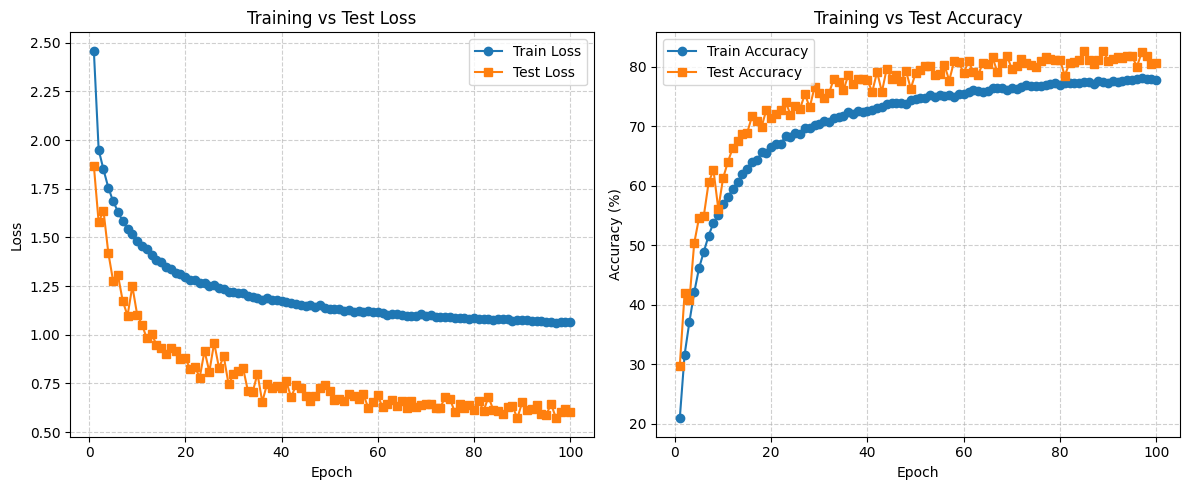

In [ ]:
# plot_metrics(fp32_metrics)

In [8]:
def evaluate(model, test_loader,device='cpu'):
  model.eval()
  model.to(device)
  correct, total = 0, 0

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device, non_blocking=True)
          labels = labels.to(device, non_blocking=True)
          outputs = model(images)
          _, pred = outputs.max(1)
          correct += pred.eq(labels).sum().item()
          total += labels.size(0)

  acc = 100.0 * correct / total
  return acc

In [ ]:
# acc = evaluate(model_fp32,test_loader,device)
# print(f"FP32 Test Accuracy: {acc}%")

Model loaded from squeezenet_fp32_final.pth


/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FP32 Test Accuracy: 80.62%


## Task 2: Quantize Squeezenet

For task 2 we use quantization aware training to quantize SqueezeNet to INT8. After training for 50 epochs we are able to achieve a final test accuracy of 69.16% with the quantized model.

In [ ]:
# import torch.nn as nn

# class Fixed16_6(nn.Module):
#     """
#     typedef ap_fixed<16, 6, AP_RND, AP_SAT> fixed_point_t;
#     """
#     def __init__(self):
#         super().__init__()
#         # self.scale = 2 ** 10  # 10 fractional bits
#         self.scale = 2 ** 4  # 4 fractional bits

#     def forward(self, x):
#         # clip to representable range
#         # x = torch.clamp(x, -32, 31.999)
#         x = torch.clamp(x, -8.0, 7.9375)
#         # quantize
#         x_q = torch.round(x * self.scale) / self.scale
#         return x_q

In [ ]:
# def apply_fixed_qat(module):
#     for name, child in list(module.named_children()):
#         # apply recursively
#         apply_fixed_qat(child)

#     if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
#         # wrap weights with fake quantization
#         module.weight_fake_quant = Fixed16_6()
#         module.bias_fake_quant = Fixed16_6() if module.bias is not None else None
#         orig_forward = module.forward

#         def new_forward(x, orig_forward=orig_forward, module=module):
#             # quantize weights
#             w_q = module.weight_fake_quant(module.weight)
#             if module.bias is not None:
#                 b_q = module.bias_fake_quant(module.bias)
#             else:
#                 b_q = None
#             return nn.functional.conv2d(x, w_q, bias=b_q, stride=module.stride, padding=module.padding) \
#                 if isinstance(module, nn.Conv2d) else nn.functional.linear(x, w_q, bias=b_q)

#         module.forward = new_forward


In [ ]:
# class ActivationQuant(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fake_quant = Fixed16_6()
#     def forward(self, x):
#         return self.fake_quant(x)

In [ ]:
# class QuantConv2d(nn.Module):
#     def __init__(self, module):
#         super().__init__()
#         self.module = module
#         self.wq = Fixed16_6()
#         self.bq = Fixed16_6() if module.bias is not None else None

#     def forward(self, x):
#         w = self.wq(self.module.weight)
#         b = self.bq(self.module.bias) if self.bq else None
#         return nn.functional.conv2d(
#             x, w, b,
#             stride=self.module.stride,
#             padding=self.module.padding,
#             dilation=self.module.dilation,
#             groups=self.module.groups,
#         )


# class QuantLinear(nn.Module):
#     def __init__(self, module):
#         super().__init__()
#         self.module = module
#         self.wq = Fixed16_6()
#         self.bq = Fixed16_6() if module.bias is not None else None

#     def forward(self, x):
#         w = self.wq(self.module.weight)
#         b = self.bq(self.module.bias) if self.bq else None
#         return nn.functional.linear(x, w, b)


In [ ]:
# def apply_qat(model):
#     for name, child in list(model.named_children()):
#         # recurse first
#         apply_qat(child)

#         if isinstance(child, nn.Conv2d):
#             setattr(model, name, QuantConv2d(child))

#         elif isinstance(child, nn.Linear):
#             setattr(model, name, QuantLinear(child))


In [ ]:
# def apply_activation_q(model):
#     for name, child in list(model.named_children()):
#         apply_activation_q(child)

#         if isinstance(child, nn.ReLU):
#             setattr(model, name, nn.Sequential(child, ActivationQuant()))


In [ ]:
# model_qat = SqueezeNetCIFAR10()
# model_qat.load_model("squeezenet_fp32_final.pth")

# # apply_qat(model_qat)
# # apply_activation_q(model_qat)

# # wrap activatons
# for name, module in list(model_qat.named_modules()):
#     if isinstance(module, nn.ReLU):
#         setattr(model_qat, name, nn.Sequential(module, ActivationQuant()))

Model loaded from squeezenet_fp32_final.pth


In [ ]:
# qat_metrics = train_model(model=model_qat,train_loader=train_loader,test_loader=test_loader,device=device,epochs=5)

Epoch [1/5] Train Loss: 1.1177, Train Acc: 75.51% Test/Val Loss: 0.6830, Test/Val Acc: 78.34%
Epoch [2/5] Train Loss: 1.1134, Train Acc: 75.53% Test/Val Loss: 0.6388, Test/Val Acc: 79.59%
Epoch [3/5] Train Loss: 1.1121, Train Acc: 75.74% Test/Val Loss: 0.6769, Test/Val Acc: 78.77%
Epoch [4/5] Train Loss: 1.1125, Train Acc: 75.79% Test/Val Loss: 0.7445, Test/Val Acc: 76.20%
Epoch [5/5] Train Loss: 1.1127, Train Acc: 75.65% Test/Val Loss: 0.6521, Test/Val Acc: 81.40%


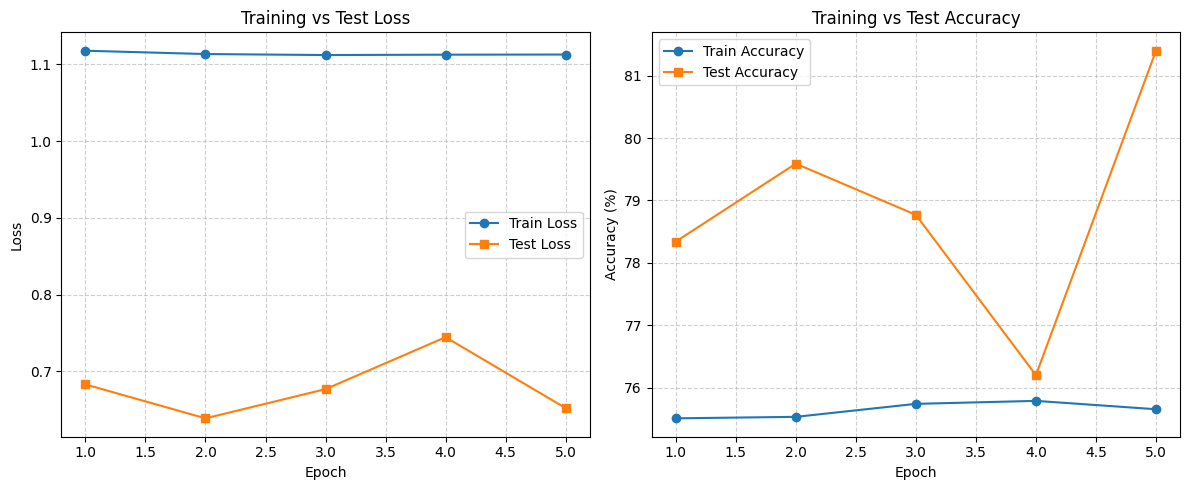

In [ ]:
# plot_metrics(qat_metrics)

In [ ]:
# model_qat.eval()
# torch.save(model_qat.state_dict(), "squeezenet_qat_fixed.pth")
# # model_int8 = convert_fx(model_qat_prepared.cpu())
# # torch.save(model_int8, "alexnet_int8_fx.pth")

In [ ]:
# acc = evaluate(model_qat,test_loader,device)
# print(f"Fixed Point Test Accuracy: {acc}%")

Fixed Point Test Accuracy: 81.4%


In [26]:
import torch
import torch.nn as nn

class Fixed8_4FakeQuant(nn.Module):
    """
    Simulates ap_fixed<8,4>:
      - integer bits = 4 → range: [-8, 7.9375]
      - fractional bits = 4 → scale = 2^4 = 16
    """
    def __init__(self):
        super().__init__()
        self.scale = 2 ** 4        # 4 fractional bits
        self.min_val = -8.0
        self.max_val = 7.9375

    def forward(self, x):
        scale = self.scale
        # must be device-aware in QAT
        scale = torch.tensor(scale, device=x.device, dtype=x.dtype)

        x = torch.clamp(x, self.min_val, self.max_val)
        x_q = torch.round(x * scale) / scale
        return x_q


In [27]:
class FixedQuantStub(nn.Module):
    def __init__(self):
        super().__init__()
        self.fake_quant = Fixed8_4FakeQuant()

    def forward(self, x):
        return self.fake_quant(x)


class FixedDeQuantStub(nn.Module):
    def __init__(self):
        super().__init__()
        # dequant for fake-quant is identity
        # (real hardware would do int8 → float here)
    def forward(self, x):
        return x

class SqueezeNetFixedQAT(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = FixedQuantStub()     # NEW
        self.model = SqueezeNetCIFAR10()  # your fp32 model
        self.dequant = FixedDeQuantStub() # NEW

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x


In [28]:
def apply_activation_q(model):
    for name, child in list(model.named_children()):
        apply_activation_q(child)
        if isinstance(child, nn.ReLU):
            setattr(model, name, nn.Sequential(child, Fixed8_4FakeQuant()))

def add_weight_quant_hooks(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            fq = Fixed8_4FakeQuant()

            def weight_hook(mod, inputs, fq=fq):
                mod.weight.data = fq(mod.weight.data)
                if mod.bias is not None:
                    # Keep bias in fp32 (best for stability)
                    pass

            module.register_forward_pre_hook(weight_hook)


In [30]:
model_qat = SqueezeNetFixedQAT()
# model_qat = SqueezeNetCIFAR10()
model_qat.model.load_model('squeezenet_fp32_final.pth')
add_weight_quant_hooks(model_qat)
apply_activation_q(model_qat)


Model loaded from squeezenet_fp32_final.pth


In [ ]:
qat_metrics = train_model(model=model_qat,train_loader=train_loader,test_loader=test_loader,device=device,epochs=5)

Epoch [1/5] Train Loss: 2.2958, Train Acc: 14.74% Test/Val Loss: 2.2830, Test/Val Acc: 21.74%
Epoch [2/5] Train Loss: 2.2888, Train Acc: 21.24% Test/Val Loss: 2.2819, Test/Val Acc: 28.63%
Epoch [3/5] Train Loss: 2.2886, Train Acc: 23.46% Test/Val Loss: 2.2818, Test/Val Acc: 25.82%
Epoch [4/5] 

In [ ]:
plot_metrics(qat_metrics)

In [ ]:
model_qat.eval()
torch.save(model_qat.state_dict(), "squeezenet_stubs.pth")

In [ ]:
acc = evaluate(model_qat,test_loader,device)
print(f"Fixed Point Test Accuracy: {acc}%")